# Maximum Likelihood Method

In [30]:
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import rv_continuous, norm
from scipy.integrate import quad
from iminuit import Minuit

In [2]:
@dataclass
class Likelihood:
    distribution: rv_continuous
    data: np.ndarray

    def __call__(self, *params):
        return np.prod(np.array([self.distribution.pdf(x, *params) for x in self.data]))


class NLL(Likelihood):
    def __call__(self, *params):
        return -np.sum(np.array([np.log(self.distribution.pdf(x, *params)) for x in self.data]))

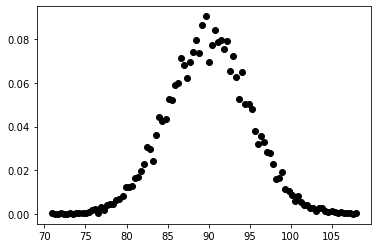

In [17]:
events = 10000
mean = 90
sigma = 5

data = norm.rvs(mean, sigma, size=events)
noise = np.random.normal(0, 0.001, events)
data += np.multiply(data, noise)

fig, ax = plt.subplots(1, 1)
nbins = 100
histo, edges = np.histogram(data, bins=nbins, density=True)
bin_centers = 0.5 * (edges[1:] + edges[:-1])
ax.plot(bin_centers, histo, 'ko');



In [18]:
nll = NLL(norm, data)
def to_minimize(mean, sigma):
    return nll(mean, sigma)

minimizer = Minuit(to_minimize, mean=80, sigma=10)
minimizer.errordef = Minuit.LIKELIHOOD
minimizer.migrad()
minimizer.hesse()

/var/folders/13/nbt0_qzj025_br3dxm0ph0sh0000gn/T/ipykernel_70234/595754631.py:6: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  minimizer.migrad()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.012e+04                  │              Nfcn = 96               │
│ EDM = 1.86e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mean  │   89.95   │   0.07    │            │            │         │         │       │
│ 1 │ sigma │   4.92    │   0.05    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │     mean    sigma │
├───────┼───────────────────┤
│  mean │  0.00484 8.38e-07 │
│ sigma │ 8.38e-07  0.00242 │
└───────┴───────────────────┘

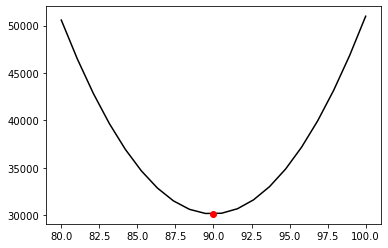

In [26]:
best_mean = minimizer.values['mean']
best_sigma = minimizer.values['sigma']
best_nll = nll(best_mean, best_sigma)

mean_test_values = np.linspace(80, 100, 20)
mean_nlls = np.array([nll(mean, best_sigma) for mean in mean_test_values])

fig, ax = plt.subplots()
ax.plot(mean_test_values, mean_nlls, 'k-');
ax.plot(best_mean, best_nll, 'ro');

/Users/massimiliano/opt/anaconda3/envs/stats-studies/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1870: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/var/folders/13/nbt0_qzj025_br3dxm0ph0sh0000gn/T/ipykernel_70234/4272348712.py:11: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.array([np.log(self.distribution.pdf(x, *params)) for x in self.data]))


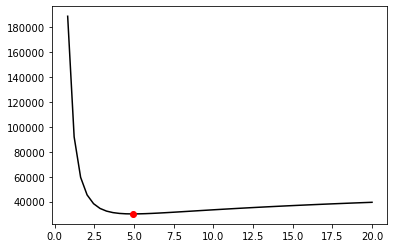

In [27]:
sigma_test_values = np.linspace(0, 20, 50)
sigma_nlss = np.array([nll(best_mean, sigma) for sigma in sigma_test_values])

fig, ax = plt.subplots()
ax.plot(sigma_test_values, sigma_nlss, 'k-');
ax.plot(best_sigma, best_nll, 'ro');

In [35]:
@dataclass
class BinnedNLL:
    distribution: rv_continuous
    histogram: np.ndarray
    edges: np.ndarray

    def __call__(self, *params):
        def probability_distribution_function(x):
            return self.distribution.pdf(x, *params)
        nu = np.array([quad(probability_distribution_function, left, right)[0] for left, right in zip(self.edges[:-1], self.edges[1:])])
        return -np.sum(np.log(np.power(nu, self.histogram)))

In [36]:
bnll = BinnedNLL(norm, histo, edges)
def to_minimize_binned(mean, sigma):
    return bnll(mean, sigma)

minimizer = Minuit(to_minimize_binned, mean=80, sigma=10)
minimizer.migrad()
minimizer.hesse()

/var/folders/13/nbt0_qzj025_br3dxm0ph0sh0000gn/T/ipykernel_70234/2283265761.py:6: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  minimizer.migrad()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 10.67                      │              Nfcn = 92               │
│ EDM = 2.07e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mean  │    90     │     4     │            │            │         │         │       │
│ 1 │ sigma │    4.9    │    3.0    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │     mean    sigma │
├───────┼───────────────────┤
│  mean │     18.1 -0.00833 │
│ sigma │ -0.00833      9.1 │
└───────┴───────────────────┘